![](img/330-banner.png)

# Lecture 18: Time series

UBC 2020-21

Instructor: Varada Kolhatkar

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, TimeSeriesSplit

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

### Lecture plan

- Announcements
- Today's dataset (5 min)
- Train/test splits with temporal data (15 min)
- Encoding date/time as feature(s) (20 min) <- we didn't cover all of this due to time
- Break (5 min)
- Lag-based features (15 min)
- Forecasting further into the future (10 min)
- Trends (5 min)
- What did we not cover? (5 min)

## Learning objectives

- Explain the pitfalls of train/test splitting with time series data.
- Appropriately split time series data, both train/test split and cross-validation.
- Perform time series feature engineering:
  - Encode time as various features in a tabular dataset 
  - Create lag-based features
- Explain different approaches for forecasting multiple time steps into the future.
- Apply "method 1"  for forecasting multiple time steps into the future, namely building a model that directly predicts $k$ steps into the future.
- Explain the challenges of time series data with unequally spaced time points.
- At a high level, explain the concepts of seasonality and trends.

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
from datetime import datetime

## Motivation

- **Time series** is a collection of data points indexed in time order. 
- Time series is everywhere:
    - Physical sciences (e.g., weather forecasting)  
    - Economics, finance (e.g., stocks, market trends)
    - Engineering (e.g., energy consumption)
    - Social sciences 
    - Sports analytics

Let's start with a simple example from [Introduction to Machine Learning with Python  book](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/). 

In New York city there is a network of bike rental stations with a subscription system. The stations are all around the city. The anonymized data is available [here](https://ride.citibikenyc.com/system-data).

We will focus on the task is predicting how many people will rent a bicycle from a particular station for a given time and day. We might be interested in knowing this so that we know whether there will be any bikes left at the station for a particular day and time.  

In [4]:
import mglearn
citibike = mglearn.datasets.load_citibike()
citibike.head()

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64

- The only feature we have is the date time feature. 
    - Example: 2015-08-01 00:00:00
- The target is the number of rentals in the next 3 hours. 
    - Example: 3 rentals between 2015-08-01 00:00:00 and 2015-08-01 03:00:00

In [5]:
citibike.index.min()

Timestamp('2015-08-01 00:00:00', freq='3H')

In [6]:
citibike.index.max()

Timestamp('2015-08-31 21:00:00', freq='3H')

We have data for August 2015. 

Text(0, 0.5, 'Rentals')

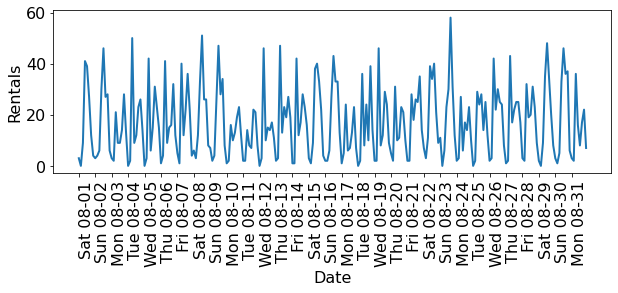

In [7]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                       freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=2)
plt.xlabel("Date")
plt.ylabel("Rentals")

- We see the day and night pattern
- We see the weekend and weekday pattern 

- Questions you might want to answer: How many people are likely to rent a bike at this station tomorrow at 3pm given everything we know about rentals in the past? 
- We want to learn from the past and predict the future. 

### Train/test split for temporal data

- What will happen if we split this data the usual way?

In [8]:
train_df, test_df = train_test_split(citibike, test_size=0.2, random_state=123)

In [9]:
test_df.head()

starttime
2015-08-26 12:00:00    30
2015-08-12 09:00:00    10
2015-08-19 03:00:00     2
2015-08-07 12:00:00    22
2015-08-03 09:00:00     9
Name: one, dtype: int64

In [10]:
train_df.index.max()

Timestamp('2015-08-31 21:00:00')

In [11]:
test_df.index.min()

Timestamp('2015-08-01 12:00:00')

- So, we are training on data that came after our test data!
- If we want to forecast, **we aren't allowed to know what happened in the future**!
- There may be cases where this is OK, e.g. if you aren't trying to forecast and just want to understand your data (maybe you're not even splitting).
- But, for our purposes, we want to avoid this.

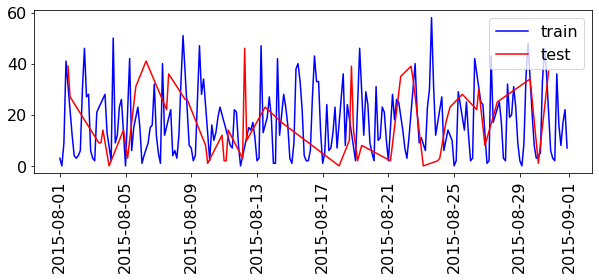

In [12]:
plt.figure(figsize=(10, 3))
train_df_sort = train_df.sort_index()
test_df_sort = test_df.sort_index()

plt.plot(train_df_sort, 'b', label='train');
plt.plot(test_df_sort, 'r', label='test');
plt.xticks(rotation='vertical');
plt.legend();

We'll split the data as follows:

- We have total 248 data points. 
- We'll use the fist 184 data points corresponding to the first 23 days as training data - And the remaining 64 data points corresponding to the remaining 8 days as test data. 

In [13]:
citibike.shape

(248,)

In [14]:
n_train = 184
train_df = citibike[:184]
test_df = citibike[184:]

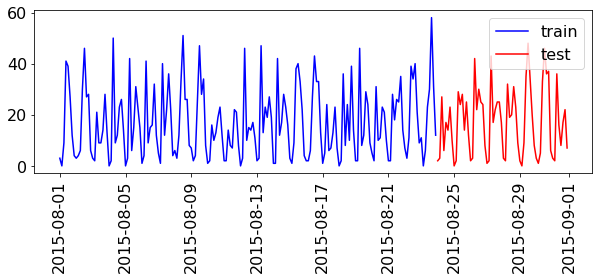

In [15]:
plt.figure(figsize=(10, 3))
train_df_sort = train_df.sort_index()
test_df_sort = test_df.sort_index()

plt.plot(train_df_sort, 'b', label='train');
plt.plot(test_df_sort, 'r', label='test');
plt.xticks(rotation='vertical');
plt.legend();

- This split is looking reasonable now. 

<br><br>

### Training models 

- In this toy data, we just have a single feature: the date time feature. 
- We need to encode this feature if we want to build machine learning models. 
- A common way that dates are stored on computers is using POSIX time, which is the number of seconds since January 1970 00:00:00 (this is beginning of Unix time). 
- Let's start with encode this feature as a single integer representing this POSIX time. 

In [16]:
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9
y = citibike.values

/var/folders/80/kr9rkqfj4w78h49djkz8yy9r0000gp/T/ipykernel_19629/621259371.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9


In [17]:
y_train = train_df.values
y_test = test_df.values
# convert to POSIX time by dividing by 10**9
X_train = train_df.index.astype("int64").values.reshape(-1, 1) // 10**9
X_test = test_df.index.astype("int64").values.reshape(-1, 1) // 10**9

/var/folders/80/kr9rkqfj4w78h49djkz8yy9r0000gp/T/ipykernel_19629/37470091.py:4: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  X_train = train_df.index.astype("int64").values.reshape(-1, 1) // 10**9
/var/folders/80/kr9rkqfj4w78h49djkz8yy9r0000gp/T/ipykernel_19629/37470091.py:5: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  X_test = test_df.index.astype("int64").values.reshape(-1, 1) // 10**9


In [18]:
y_train[:10]

array([ 3,  0,  9, 41, 39, 27, 12,  4,  3,  4])

In [19]:
X_train[:10]

array([[1438387200],
       [1438398000],
       [1438408800],
       [1438419600],
       [1438430400],
       [1438441200],
       [1438452000],
       [1438462800],
       [1438473600],
       [1438484400]])

- Our prediction task is a regression task. 

Let's try random forest regression. 

In [20]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)

print("Train-set R^2: {:.2f}".format(regressor.score(X_train, y_train)))
print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))

Train-set R^2: 0.85
Test-set R^2: -0.04


In [21]:
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Train-set R^2: {:.2f}".format(regressor.score(X_train, y_train)))    
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,
               ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")


Train-set R^2: 0.85
Test-set R^2: -0.04


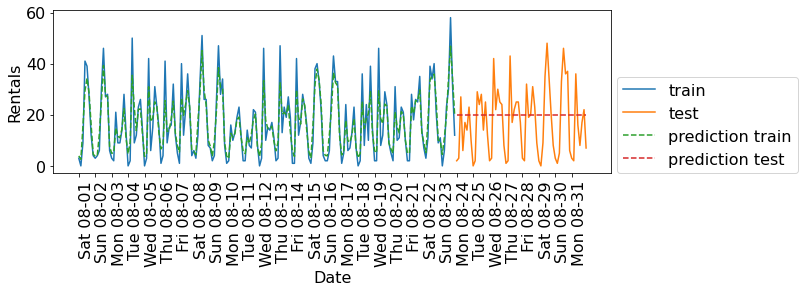

In [22]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

- The predictions on the training score is pretty good 
- But for the test data, a constant line is predicted ...
- What's going on? 

- The model is based on only one feature: POSIX time feature. 
- And the value of the POSIX time feature is outside the range of the feature values in the training set. 
- Tree-based models cannot _extrapolate_ to feature ranges outside the training data. 
- The model predicted the target value of the closest point in the training set. 

Can we come up with better features? 

### Feature engineering for date/time columns

We noted before that the time of the day and day of the week seem quite important. 
Let's add these two features. 

Train-set R^2: 0.50
Test-set R^2: 0.60


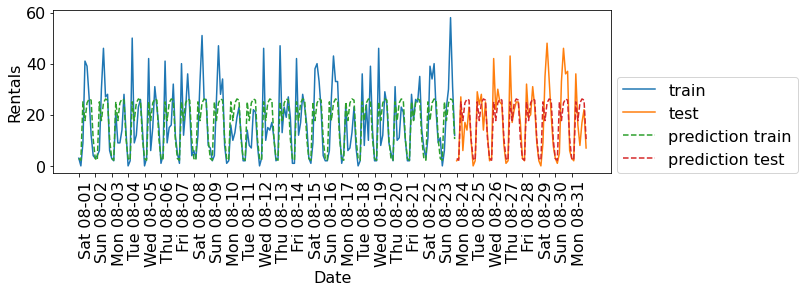

In [23]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

Train-set R^2: 0.89
Test-set R^2: 0.84


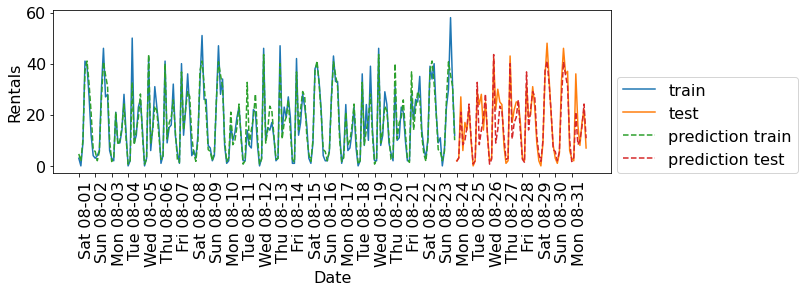

In [24]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

Train-set R^2: 0.16
Test-set R^2: 0.13


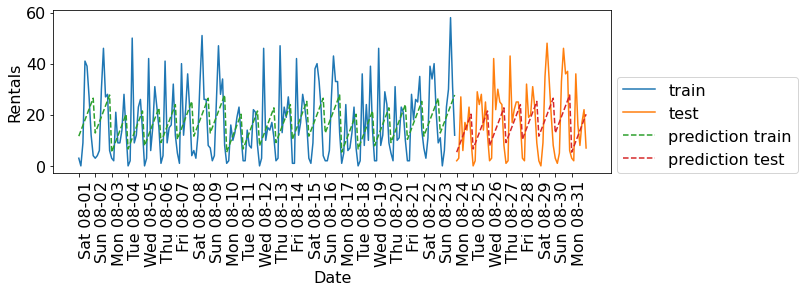

In [25]:
from sklearn.linear_model import Ridge

lr = Ridge()
eval_on_features(X_hour_week, y, lr)

- Ridge is performing poorly on the training as well as test data.
- It's not able to capture the periodic pattern.
- The reason is that we have encoded time of day using integers. 
- A linear function can only learn a linear function of the time of day. 
- What if we encode this feature as a categorical variable? 

In [26]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

Train-set R^2: 0.53
Test-set R^2: 0.62


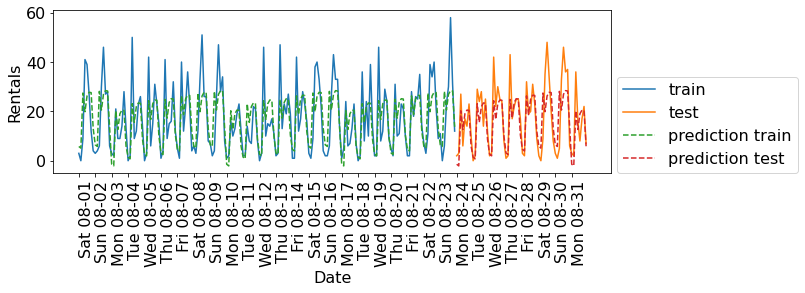

In [27]:
eval_on_features(X_hour_week_onehot, y, Ridge())

In [28]:
X_hour_week_onehot
X_hour_week_onehot.shape

(248, 15)

Train-set R^2: 0.87
Test-set R^2: 0.85


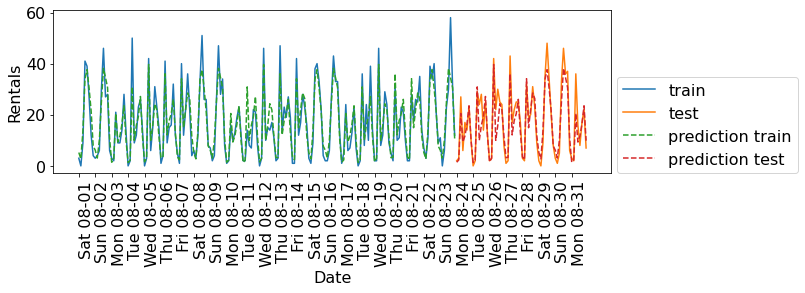

In [29]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

In [30]:
X_hour_week_onehot_poly.shape

(248, 120)

In [31]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features =  day + hour
features

['Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 '00:00',
 '03:00',
 '06:00',
 '09:00',
 '12:00',
 '15:00',
 '18:00',
 '21:00']

In [32]:
features_poly = poly_transformer.get_feature_names(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

In [33]:
pd.DataFrame(coef_nonzero, index = features_nonzero, columns=['Coefficient']).sort_values('Coefficient', ascending=False)

,Coefficient
Sat 09:00,15.196739
Wed 06:00,15.005809
Sat 12:00,13.437684
Sun 12:00,13.362009
Thu 06:00,10.907595
...,...
Sat 21:00,-6.085150
00:00,-11.693898
03:00,-12.111220
Sat 06:00,-13.757591


The coefficients make sense!

### Cross-validation

What about cross-validation? 

- We can't do regular cross-validation if we don't want to be predicting the past.
- If you carry out regular cross-validation, you'll be predicting the past given future which is not a realistic scenario for the deployment data. 

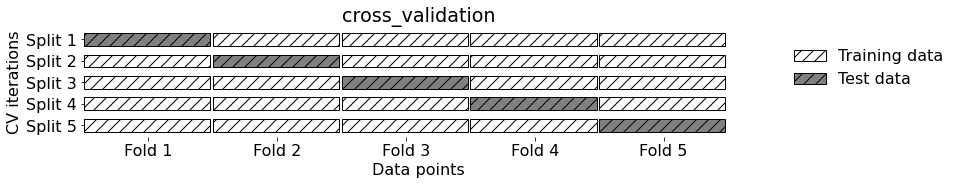

In [34]:
mglearn.plots.plot_cross_validation()

There is [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) for time series data. 

In [35]:
from sklearn.model_selection import TimeSeriesSplit

In [37]:
X_toy = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y_toy = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(X_toy):
    print("%s %s" % (train, test))

[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


In [38]:
rf = RandomForestRegressor()

In [43]:
scores = cross_validate(rf, X_hour_week_onehot, y, cv=TimeSeriesSplit(), return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.072361,0.005676,0.625655,0.885520
1,0.072222,0.005550,0.853924,0.906867
2,0.070288,0.005516,0.769141,0.928151
3,0.073669,0.005327,0.676215,0.911205
4,0.073593,0.005173,0.912172,0.877482


## Today's dataset (5 min)

[Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) dataset. Predicting whether or not it will rain tomorrow based on today's measurements.

In [ ]:
df_rain = pd.read_csv("data/weatherAUS.csv")
df_rain.head()

#### Goals

- Can the date/time features help us predict the target value?
- Can we **forecast** into the future?

Fun fact:

In [ ]:
df_rain["Rainfall"].max()

3.7 mm of rain in one day?!?

#### Parsing datetimes 

- In general, datetimes are a huge pain! Think of all the formats: MM-DD-YY, DD-MM-YY, YY-MM-DD, MM/DD/YY, DD/MM/YY, DD/MM/YYYY, 20:45, 8:45am, 8:45 PM, 8:45a, 08:00, 8:10:20, .......
- No, seriously, dealing with datetimes is THE WORST.
  - Time zones.
  - Daylight savings...
- Thankfully, pandas does a pretty good job here.

In [ ]:
dates_rain = pd.to_datetime(df_rain["Date"])
dates_rain

They are all the same format, so we can also compare dates:

In [ ]:
dates_rain[1] - dates_rain[0]

In [ ]:
dates_rain[1] > dates_rain[0]

In [ ]:
(dates_rain[1] - dates_rain[0]).total_seconds()

You can tell pandas to parse the dates when reading in the CSV:

In [ ]:
df_rain = pd.read_csv("data/weatherAUS.csv", parse_dates=["Date"])
df_rain.head()

In [ ]:
df_rain["Date"].head()

## Train/test splits with temporal data (15 min)

Let's do the usual thing we do...

In [ ]:
df_train, df_test = train_test_split(df_rain, random_state=123)

In [ ]:
def preprocess_features(df_train, df_test, numeric_features, categorical_features, drop_features):

    all_features = set(numeric_features + categorical_features + drop_features)
    if set(df_train.columns) != all_features:
        print("Missing columns", set(df_train.columns) - all_features)
        print("Extra columns", all_features - set(df_train.columns))
        raise Exception("Columns do not match")
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])  
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])
    preprocessor.fit(df_train);

    ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']
    ohe_feature_names = list(ohe.get_feature_names(categorical_features))
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(preprocessor.transform(df_train).toarray(), index=df_train.index, columns=new_columns)
    X_test_enc  = pd.DataFrame(preprocessor.transform(df_test).toarray(),  index=df_test.index,  columns=new_columns)
    
    y_train = df_train["RainTomorrow"]
    y_test  = df_test["RainTomorrow"]
    
    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [ ]:
numeric_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
                    'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 
                    'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
categorical_features = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
drop_features = ['RISK_MM', 'Date', 'RainTomorrow']  # See the documentation, should not keep the column

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features, categorical_features, drop_features)

In [ ]:
X_train_enc

Now we do the modelling:

In [ ]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [ ]:
lr_pipe.fit(df_train, y_train);

In [ ]:
lr_pipe.score(df_train, y_train)

In [ ]:
lr_pipe.score(df_test, y_test)

- But, wait a minute, I did something wrong. Any ideas?

<br><br><br><br><br><br>

- Let's look at the dates in our train/test split:

In [ ]:
df_train["Date"].max()

In [ ]:
df_test["Date"].min()

- So, we are training on data that came before our test data!
- If we want to forecast, we aren't allowed to know what happened in the future!
- There may be cases where this is OK, e.g. if you aren't trying to forecast and just want to understand your data (maybe you're not even splitting).
- But, for our purposes, we want to avoid this.

In [ ]:
# test_pred = df_test.sort_values(by=["Location", "Date"])
# np.mean(test_pred["RainToday"].iloc[1:].values == test_pred["RainTomorrow"].iloc[-1:].values)

In [ ]:
df_train_sort = df_train.query("Location == 'Sydney'").sort_values(by="Date")
df_test_sort = df_test.query("Location == 'Sydney'").sort_values(by="Date")

plt.plot(df_train_sort["Date"], df_train_sort["Rainfall"], 'b', label='train');
plt.plot(df_test_sort["Date"], df_test_sort["Rainfall"], 'r', label='test');
plt.xticks(rotation='vertical');
plt.legend();
plt.ylabel("Rainfall (mm)");
plt.title("Train/test rainfall in Sydney");

In [ ]:
df_rain["Date"].min()

In [ ]:
df_rain["Date"].max()

- It looks like we have 10 years of data.
- Let's use the last 2 years for test.

In [ ]:
df_train = df_rain.query('Date <= 20150630')
df_test  = df_rain.query('Date >  20150630')

In [ ]:
len(df_train)

In [ ]:
len(df_test)

In [ ]:
len(df_test)/(len(df_train)+len(df_test))

As we can see, we're still using about 25% of our data as test data.

In [ ]:
df_train_sort = df_train.query("Location == 'Sydney'").sort_values(by="Date")
df_test_sort = df_test.query("Location == 'Sydney'").sort_values(by="Date")

plt.plot(df_train_sort["Date"], df_train_sort["Rainfall"], 'b', label='train');
plt.plot(df_test_sort["Date"], df_test_sort["Rainfall"], 'r', label='test');
plt.xticks(rotation='vertical');
plt.legend();
plt.ylabel("Rainfall (mm)");
plt.title("Train/test rainfall in Sydney");

We're learning relationships from the blue part; predicting only using features in the red part from the day before.

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features, categorical_features, drop_features)

In [ ]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [ ]:
lr_pipe.fit(df_train, y_train);

In [ ]:
lr_pipe.score(df_train, y_train)

In [ ]:
lr_pipe.score(df_test, y_test)

- In this case it didn't seem to really matter - we get about the same scores.
- However, in general we should split conservatively if we can.

In [ ]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

In [ ]:
dc = DummyClassifier(strategy='prior')
dc.fit(df_train, y_train);

In [ ]:
dc.score(df_train, y_train)

In [ ]:
y_train.value_counts()

In [ ]:
dc.score(df_test, y_test)

#### Cross-validation

What about cross-validation? 

- We can't do regular cross-validation if we don't want to be predicting the past.
- Cross-validation randomly shuffles the rows, so you might get rows in your training set that occur after rows in your validation set. This isn't 100% terrible in that you're still predicting next week's price regardless, but it's not a good idea. Especially if there are trends in the dataset, and then you get to see what happened to the trend in the future.
- Actually, our training split is a bit weird because we "have the answers" in the training set. But our testing procedure is conservative.
- If we want, there is:

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

see https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split

However, things are actually more complicated here because this dataset has **multiple time series**, one per location. 

In [ ]:
df_train

In [ ]:
df_train.sort_values(by=["Date"]).tail()

- It seems the dataframe is sorted by location, and then time. 
- Our approach today will be to ignore the fact that we have multiple time series and just OHE the location
- We'll have multiple measurements for a given timestamp, and that's OK.
- But, `TimeSeriesSplit` expects the dataframe to be sorted by date so...

In [ ]:
df_train_ordered = df_train.sort_values(by=["Date"])
y_train_ordered = df_train_ordered["RainTomorrow"]

In [ ]:
cross_val_score(lr_pipe, df_train_ordered, y_train_ordered, cv=TimeSeriesSplit()).mean()

- This gives us a slightly more conservative (lower) score than a regular "shuffle split" CV.
  - Not sure if that is meaningful or just randomness
- Note that I have to explicitly tell it to shuffle because we didn't do a `train_test_split` which is where our shuffling usually comes from.

In [ ]:
from sklearn.model_selection import ShuffleSplit

In [ ]:
cross_val_score(lr_pipe, df_train, y_train, cv=ShuffleSplit()).mean()

If you do unshuffled CV the score is significantly lower:

In [ ]:
cross_val_score(lr_pipe, df_train, y_train).mean()

- This was a head-scratcher
- I believe it may be because of the locations, and the lack of shuffling
- We want each split to have some of all locations, but this way we might have nothing from a given location in the train set

## Encoding date/time as feature(s) (20 min)

- Can we use the `Date` to help us predict the target?
- Probably! E.g. different amounts of rain in different seasons.
- This is feature engineering!

#### Encoding time as an number

- Idea 1: create a column of "days since Nov 1, 2007".

In [ ]:
first_day = df_train["Date"].min()

df_train = df_train.assign(Days_since=df_train["Date"].apply(lambda x: (x-first_day).days))
df_test = df_test.assign(Days_since=df_test["Date"].apply(lambda x: (x-first_day).days))

In [ ]:
df_train.sort_values(by='Date').head()

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features  + ["Days_since"], 
        categorical_features, 
        drop_features)

In [ ]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [ ]:
lr_pipe.fit(df_train, y_train);

In [ ]:
lr_pipe.score(df_train, y_train)

In [ ]:
lr_pipe.score(df_test, y_test)

- Can you think of other ways to generate features from the `Date` column? 
- What about the month - that seems relevant. How should we encode the month? 

<br><br><br><br><br><br>

Another idea month: encode as integer, categorical variable?

#### One-hot encoding of the month

In [ ]:
df_train = df_rain.query('Date <= 20150630')
df_test  = df_rain.query('Date >  20150630')

In [ ]:
df_train = df_train.assign(Month=df_train["Date"].apply(lambda x: x.month)) # x.month_name() to get the actual string
df_test  = df_test.assign( Month=df_test[ "Date"].apply(lambda x: x.month))

# TODO 

change to month name for this part

In [ ]:
df_train[["Date", "Month"]].sort_values(by="Month")

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features, 
        categorical_features + ["Month"], 
        drop_features)

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [ ]:
lr_pipe.fit(df_train, y_train);

In [ ]:
lr_pipe.score(df_train, y_train)

In [ ]:
lr_pipe.score(df_test, y_test)

In [ ]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

In [ ]:
lr_coef.loc["Month_1":"Month_12"]

#### One-hot encoding seasons

How about just summer/winter as a feature?

In [ ]:
WINTER_MONTHS = {5,6,7,8,9}
df_train = df_train.assign(Winter=df_train["Month"].isin(WINTER_MONTHS))
df_test  = df_test.assign( Winter=df_test[ "Month"].isin(WINTER_MONTHS))

In [ ]:
df_train

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features + ["Winter"], 
        categorical_features, 
        drop_features + ["Month"])

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [ ]:
lr_pipe.fit(df_train, y_train);

In [ ]:
lr_pipe.score(df_train, y_train)

In [ ]:
lr_pipe.score(df_test, y_test)

In [ ]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

In [ ]:
lr_coef.loc["Winter"]

- It's a bit surprising that these features don't help much.


In [ ]:
df_train.plot(x="Date", y="Rainfall");
plt.ylabel("Rainfall (mm)");

In [ ]:
monthly_avg_rainfall = df_train.groupby("Month")["Rainfall"].mean()
plt.plot(monthly_avg_rainfall);
plt.xticks(np.arange(1,13).astype(int));
plt.ylabel("Avg rainfall (mm)");
plt.xlabel("Month");

In [ ]:
df_train.sort_values(by="Date", ascending=False)

- This pattern is pretty surprising to me - why is June rainy but May and August are less so?
- But, Australia is a huge country. Perhaps we should drill down to particular locations:

In [ ]:
df_train_canberra  = df_train.query('Location == "Canberra"')

In [ ]:
plt.plot(df_train_canberra["Date"], df_train_canberra["Rainfall"]);
plt.ylabel("Rainfall (mm)");

In [ ]:
plt.plot(df_train_canberra.groupby("Month")["Rainfall"].mean());
plt.xticks(np.arange(1,13).astype(int));
plt.ylabel("Avg rainfall (mm)");
plt.xlabel("Month");
plt.title("Rainfall in Canberra");

In [ ]:
df_train_canberra.shape

- This looks somewhat cleaner but also pretty surprising - why is December so much higher than January?
- This is called _seasonality_.
- Why was the month feature not that useful? Perhaps this was already captured in the other features.
  - But also the encoding wasn't ideal.

#### Periodic encoding

- We can also try a periodic encoding.
- This works because we know the periodicity (annual).
- We can use a sin and cos with period 1 year.
- You can shift the period by adding together $\sin(x)$ and $\cos(x)$:

In [ ]:
WINTER_MONTHS = {5,6,7,8,9}
df_train = df_train.assign(Winter=df_train["Month"].isin(WINTER_MONTHS))
df_test  = df_test.assign( Winter=df_test[ "Month"].isin(WINTER_MONTHS))

In [ ]:
df_train = df_train.assign(Month_sin = np.sin(2*np.pi*df_train["Month"]/12))
df_train = df_train.assign(Month_cos = np.cos(2*np.pi*df_train["Month"]/12))

df_test = df_test.assign(Month_sin = np.sin(2*np.pi*df_test["Month"]/12))
df_test = df_test.assign(Month_cos = np.cos(2*np.pi*df_test["Month"]/12))

In [ ]:
month = np.arange(1,13)
enc_sin = np.sin(2*np.pi*month/12)
enc_cos = np.cos(2*np.pi*month/12)
plt.plot(month,enc_sin);
plt.plot(month,enc_cos, 'r');

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features + ["Month_sin", "Month_cos"], 
        categorical_features, 
        drop_features + ["Month", "Winter"])

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [ ]:
lr_pipe.fit(df_train, y_train);

In [ ]:
lr_pipe.score(df_train, y_train)

In [ ]:
lr_pipe.score(df_test, y_test)

In [ ]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.loc[["Month_sin", "Month_cos"]]

**From Piazza last year**

Q: How to interpret coefficients for periodic encoded features?

A: They are both negative, so it means the price is higher when sin(2 pi month / 12) is lower and when cos(2 pi month / 12) is lower. In fact, since this is a linear model, we can just combine them: it means the price is higher when -0.016 sin(2 pi month / 12) - 0.013 cos(2 pi month / 12) is high. You can plot this function. I plotted it - see attached image. It shows that the predicted price is higher roughly from months 5-11, meaning May-November, with the lowest price falling around Jan-Feb and the highest price around August.

Optional note: by following trigonometric identities, we can see that learning  $A\sin(x)+B\cos(x)$  is the same as learning  $C\sin(x-\phi)$, or in other words a phase-shifted sine wave. 

However, all this only applies because it's a linear model. For something like a random forest, these coefficients would be harder to interpret.


#### Encoding average monthly rainfall 

We can also try encoding the average rainfall for that month a a feature:

In [ ]:
monthly_avg_rainfall = df_train.groupby("Month")["Rainfall"].mean()
monthly_avg_rainfall

In [ ]:
df_train = df_train.assign(Monthly_rainfall = df_train["Date"].apply(lambda x: monthly_avg_rainfall[x.month]))
df_test = df_test.assign(Monthly_rainfall = df_test["Date"].apply(lambda x: monthly_avg_rainfall[x.month]))

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features + ["Monthly_rainfall"], 
        categorical_features, 
        drop_features + ["Month", "Winter", "Month_sin", "Month_cos"])

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [ ]:
lr_pipe.fit(df_train, y_train);

In [ ]:
lr_pipe.score(df_train, y_train)

In [ ]:
lr_pipe.score(df_test, y_test)

In [ ]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.loc["Monthly_rainfall"]

- Hmm, it's a bit worrying that this coefficient is negative...
- Unless I have a bug in my code, this is a prime example of the dangers of interpreting coefficients too literally. 
- If we trained a model with _only_ this feature:

In [ ]:
monthly_rain = df_train["Date"].apply(lambda x: monthly_avg_rainfall[x.month]).values[:,None]

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(monthly_rain, y_train)
lr.coef_

- Even here we get a negative coefficient, very bizarre.
- We'll get a sensible result in a second:

#### Average monthly rainfall by location

In [ ]:
avg_monthly_rainfall_by_loc = df_train.groupby(["Month", "Location"])["Rainfall"].mean()

In [ ]:
df_train = df_train.assign(Monthly_rainfall_at_loc = df_train.apply(lambda x: avg_monthly_rainfall_by_loc.loc[(x["Date"].month, x["Location"])], axis=1))
df_test = df_test.assign(Monthly_rainfall_at_loc = df_test.apply(lambda x: avg_monthly_rainfall_by_loc.loc[(x["Date"].month, x["Location"])], axis=1))

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features + ["Monthly_rainfall_at_loc"], 
        categorical_features, 
        drop_features + ["Month", "Winter", "Month_sin", "Month_cos", "Monthly_rainfall"])

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [ ]:
lr_pipe.fit(df_train, y_train);

In [ ]:
lr_pipe.score(df_train, y_train)

In [ ]:
lr_pipe.score(df_test, y_test)

In [ ]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.loc["Monthly_rainfall_at_loc"]

## Break (5 min)

REMINDER TO RESUME RECORDING

## Lag-based features (15 min)

- Currently we're using features about today to predict tomorrow's rainfall.
- But, what if tomorrow's rainfall is also related to yesterday's features, or the day before?
  - This is called a _lagged_ feature.
- In time series analysis, we'd look at something called an [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) (ACF), but we won't go into that here.
- Instead, we can just add those features:

In [ ]:
df_train = df_rain.query('Date <= 20150630')
df_test  = df_rain.query('Date >  20150630')

In [ ]:
df_train

- It looks like the dataframe is already sorted by Location and then by date for each Location.
- We could have done this ourselves with

In [ ]:
# df_train.sort_values(by=["Location", "Date"])

But make sure to also sort the targets (i.e. do this before preprocessing).

In [ ]:
def create_lag_feature(df, orig_feature, lag):
    """Creates a new df with a new feature that's a lagged version of the original, where lag is an int."""
    # note: pandas .shift() kind of does this for you already, but oh well I already wrote this code
    
    new_df = df.copy()
    new_feature_name = "%s_lag%d" % (orig_feature, lag)
    new_df[new_feature_name] = np.nan
    for location, df_location in new_df.groupby("Location"): # Each location is its own time series
        new_df.loc[df_location.index[lag:],new_feature_name] = df_location.iloc[:-lag][orig_feature].values
    return new_df

In [ ]:
df_train = create_lag_feature(df_train, "Rainfall", 1)

In [ ]:
df_train[["Date", "Location", "Rainfall", "Rainfall_lag1"]].head(20)

In [ ]:
df_train[["Date", "Location", "Rainfall", "Rainfall_lag1"]][2285:2295]

- Looks good.

- Question: is it OK to do this to the test set? Discuss.

<br><br><br><br><br><br>

- It's fine if you would have this information available in deployment.
- If we're just forecasting the next day, we should.
- Let's include it for now.

Another question: is there a difference between doing this and then splitting, vs. splitting and then doing this?

<br><br><br><br><br><br>

- Answer: a tiny difference: the first day of the test set, for each location, will have a `NaN`. 
  - That might actually be too strict.
  - It should be fine to do this before splitting.

In [ ]:
df_rain_modified = create_lag_feature(df_rain, "Rainfall", 1)

In [ ]:
df_train = df_rain_modified.query('Date <= 20150630')
df_test  = df_rain_modified.query('Date >  20150630')

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features + ["Rainfall_lag1"], 
        categorical_features, 
        drop_features)

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [ ]:
lr_pipe.fit(df_train, y_train);

In [ ]:
lr_pipe.score(df_train, y_train)

In [ ]:
lr_pipe.score(df_test, y_test)

In [ ]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

In [ ]:
lr_coef.loc[["Rainfall", "Rainfall_lag1"]]

- We could also create a lagged version of the target.
- In fact, this dataset already has that built in! `RainToday` is the lagged version of the target `RainTomorrow`.
- We could also created lagged version of other features, or more lags

In [ ]:
df_rain_modified = create_lag_feature(df_rain, "Rainfall", 1)
df_rain_modified = create_lag_feature(df_rain_modified, "Rainfall", 2)
df_rain_modified = create_lag_feature(df_rain_modified, "Rainfall", 3)
df_rain_modified = create_lag_feature(df_rain_modified, "Humidity3pm", 1)

In [ ]:
df_rain_modified[['Date', 'Location', 'Rainfall', 'Rainfall_lag1', 'Rainfall_lag2', 'Rainfall_lag3', 'Humidity3pm', 'Humidity3pm_lag1']].head(10)

Note the pattern of `NaN` values. 

In [ ]:
df_train = df_rain_modified.query('Date <= 20150630')
df_test  = df_rain_modified.query('Date >  20150630')

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, 
        numeric_features + ['Rainfall_lag1', 'Rainfall_lag2', 'Rainfall_lag3', 'Humidity3pm_lag1'], 
        categorical_features, 
        drop_features)

lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [ ]:
lr_pipe.fit(df_train, y_train);

In [ ]:
lr_pipe.score(df_train, y_train)

In [ ]:
lr_pipe.score(df_test, y_test)

In [ ]:
lr_coef = pd.DataFrame(data=np.squeeze(lr_pipe[1].coef_), index=X_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

In [ ]:
lr_coef.loc[['Rainfall', 'Rainfall_lag1', 'Rainfall_lag2', 'Rainfall_lag3', 'Humidity3pm', 'Humidity3pm_lag1']]

In [ ]:
df_train.head()

## Forecasting further into the future (10 min)

- Let's say we want to predict 7 days into the future instead of one day.
- There are a few main approaches here:

1. Train a separate model for each number of days. E.g. one model that predicts RainTomorrow, another model that predicts RainIn2Days, etc. We can build these datasets.
2. Use a multi-output model that jointly predicts RainTomorrow, RainIn2Days, etc. However, multi-output models are outside the scope of CPSC 330. 
3. Use one model and sequentially predict using a `for` loop. However, this requires predicting _all_ features into a model so may not be that useful here.

So, I'll recommend Approach 1 to you, even though it's a bit unwieldy. 

- To briefly dig into approach 3, this is easier to understand for a univariate (one feature) time series. 
- To dig into this we'll look at the [Retail Sales of Clothing and Clothing Accessory Stores dataset](https://fred.stlouisfed.org/series/MRTSSM448USN) made available by the Federal Reserve Bank of St. Louis.

In [ ]:
retail_df = pd.read_csv('data/retail_sales_timeseries.csv', parse_dates=["DATE"])
retail_df.columns=["date", "sales"]

In [ ]:
retail_df.head()

In [ ]:
retail_df['date'].min()

In [ ]:
retail_df['date'].max()

In [ ]:
retail_df_train = retail_df.query('date <= 20170101')
retail_df_test  = retail_df.query('date >  20170101')

In [ ]:
retail_df_train.plot(x="date", y="sales", figsize=(15,5));

We can create a dataset using purely lag features.

In [ ]:
def lag_df(df, lag, cols):
    return df.assign(**{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols})

In [ ]:
retail_lag_5 = lag_df(retail_df, 5, ["sales"])
retail_train_5 = retail_lag_5.query('date <= 20170101')
retail_test_5  = retail_lag_5.query('date >  20170101')
retail_train_5

- Now, if we drop the "date" column we have a target ("sales") and 5 features (the previous 5 days of sales).
- We need to impute/drop the missing values and then we can fit a model to this. I will just drop for convenience:

In [ ]:
retail_train_5 = retail_train_5[5:].drop(columns=["date"])
retail_train_5

In [ ]:
retail_train_5_X = retail_train_5.drop(columns=["sales"])
retail_train_5_y = retail_train_5["sales"]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
retail_model = RandomForestRegressor()
retail_model.fit(retail_train_5_X, retail_train_5_y);

Given this, we can now predict the sales

In [ ]:
preds = retail_model.predict(retail_test_5.drop(columns=["date", "sales"]))
preds

In [ ]:
retail_test_5_preds = retail_test_5.assign(predicted_sales = preds)
retail_test_5_preds.head()

- Ok, that is fine, but what if we want to predict 7 days in the future? 
- Well, we would not have access to our features!! We don't yet know the previous day's sales, or 2 days prior! 
- So we can use "Approach 3" mentioned earlier: predict these values and then pretend they are true!
- For simplicity, say today is Monday

1. Predict Tuesday's sales
2. Then, to predict for Wednesday, we need to know Tuesday's sales. Use our _prediction_ for Tuesday as the truth.
3. Then, to predict for Thursday, we need to know Tue and Wed sales. Use our predictions.
4. Etc etc.

Let's take a look at [Tom's timeseries tutorial](https://github.com/TomasBeuzen/machine-learning-tutorials/blob/master/ml-timeseries/notebooks/supervised_time_series_intro.ipynb) for what this looks like.

## Trends (5 min)

- I kind of regret picking the Rain in Australia dataset because it has a binary target value.
- There are some important concepts in time series that rely on having a continuous target (like we do in the retail sales example above).
- Part of that is the idea of seasonality and trends.
- These are mostly taken care of by our feature engineering of the data variable, but there's something important left to discuss.

In [ ]:
retail_df_train.plot(x="date", y="sales", figsize=(15,5));

- It looks like there's a **trend** here - the sales are going up over time. 
- This is somewhat captured by the fact that you can look at the last 5 time points, which will also be higher.
- But if you want to forecast much farther into the future, nothing in our model accounts for the trend. 
- This is seen in the forecasts in Tom's notebook. 

Let's say we encoded the date as a feature in days like this:

In [ ]:
retail_train_5_date = retail_lag_5.query('date <= 20170101')
first_day_retail = retail_train_5_date["date"].min()

retail_train_5_date.assign(Days_since=retail_train_5_date["date"].apply(lambda x: (x-first_day_retail).days))

- Now, let's say we use all these features (the lagged version of the target and also `Days_since`.
- If we use **linear regression** we'll learn a coefficient for `Days_since`. 
  - If that coefficient is positive, it predicts unlimited growth forever. That may not be what you want? It depends.
- If we use a **random forest**, we'll just be doing splits from the training set, e.g. "if `Days_since` > 9100 then do this".
  - There will be no splits for later time points because there is no training data there.
  - Thus tree-based models cannot model trends.
  - This is really important to know!!
- Often, we model the trend separately and use the random forest to model a de-trended time series.

## What did we not cover? (5 min)

- A huge amount!

#### Traditional time series approaches

- Time series analysis is a huge field of its own (notice a pattern here?)
- Traditional approaches include the [ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and its various components/extensions.
- In Python, the [statsmodels](https://www.statsmodels.org/) package is the place to go for this sort of thing.
  - For example, [statsmodels.tsa.arima_model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html).
- These approaches can forecast, but they are also very good for understanding the temporal relationships in your data.
- We will take a different route in this course, and stick to our supervised learning tools.

#### Deep learning 

- Recently, deep learning has been very successful too.
- In particular, [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNNs).
  - These are not covered in CPSC 340, but I believe they are in 540 (soon to be renamed 440).
  - [LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) especially have shown a lot of promise in this type of task.
  - [Here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a blog post about LSTMs.
  - [Here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) is the documentation for the LSTM in tf.keras.

#### Types of problems involving time series

- A single label associated with an entire time series. 
  - We had that with images earlier on, you could have the same for a time series.
  - E.g., for fraud detection, labelling each transaction as fraud/normal vs. labelling a person as bad/good based on their entire history.
  - There are various approaches that can be used for this type of problem, including CNNs (Lecture 14), LSTMs, and non deep learning methods.
- Inference problems.
  - What are the patterns in this time series?
  - How many lags are associated with the current value?
 - Etc.

#### Unequally spaced time points

- We assumed we have a measurement each day.
- For example, when creating lag features we used consecutive rows in the DataFrame.
- But, in fact some days were missing in this dataset.
- More generally, what if the measurements are at arbitrary times, not equally spaced?
  - Some of our approaches would still work, like encoding the month / looking at seasonality.
  - Some of our approaches would not make sense, like the lags.
  - Perhaps the measurements could be binned into equally spaced bins, or something.
  - This is more of a hassle.

#### Other software package

- One good one to know about is [Prophet](https://facebook.github.io/prophet/docs/quick_start.html).

#### Feature engineering

- Often, a useful approach is to just _engineer your own features_.
  - E.g., max expenditure, min expenditure, max-min, avg time gap between transactions, variance of time gap between transactions, etc etc.
  - We could do that here as well, or in any problem.


## T/F questions (Piazza)

1. The rain in Australia dataset contains a single time series; that is, each date has a unique row associated with it.
2. A reasonable approach to encoding the date would be one-hot encoding the days of the year (from 1-365).
3. It is better to OHE the month than to encode it as an integer (i.e. ordinal).
4. It is important to train/test split before we create our lagged features.
5. If we have a feature with lag 3 in our dataset, that feature will be missing if we try to forecast 5 days into the future.

<br><br><br><br><br><br>